# Customer Segmentation From RFM Value

This code will perform RFM analysis and Kmeans clustering to build a segmentation for each customer. <br><br>
**Business Objective**: To understand customer purchasing behavior to **`prioritize marketing by customer groups`** and **`send relevant(personalized) promotions`** to existing customers. <br>

Data Source:
- [Online Retail Dataset](https://archive.ics.uci.edu/ml/datasets/online+retail)

Dataset Attributes:

- **InvoiceNo**: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
- **StockCode**: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
- **Description**: Product (item) name. Nominal.
- **Quantity**: The quantities of each product (item) per transaction. Numeric.
- **InvoiceDate**: Invice date and time. Numeric. The day and time when a transaction was generated.
- **UnitPrice**: Unit price. Numeric. Product price per unit in sterling (Â£).
- **CustomerID**: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
- **Country**: Country name. Nominal. The name of the country where a customer resides.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
import warnings
warnings.filterwarnings(action="ignore")

In [2]:
data_url = "data/online_retail.csv"

retail = pd.read_csv(data_url, encoding='unicode_escape', dtype={'InvoiceNo': object, 'CustomerID': object}, parse_dates=['InvoiceDate'], infer_datetime_format=True)
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [3]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
retail.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


### drop the rows whose customer id is N/A

In [5]:
retail.drop(index=retail[retail.CustomerID.isna()].index, inplace=True)

### drop the rows whose quantity or unit price is negative

In [6]:
#idx = retail.index[(retail['Quantity']<0)|(retail['UnitPrice']<0)].tolist()
#retail = retail.drop(index=idx, axis=0)
retail.drop(index=retail[(retail['Quantity']<0)|(retail['UnitPrice']<0)].index, inplace=True)
retail.describe()

,Quantity,UnitPrice
count,397924.000000,397924.000000
mean,13.021823,3.116174
std,180.420210,22.096788
min,1.000000,0.000000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


## Assign Daily Acquisition Cohort and Monthly Acquisition Cohort

In [7]:
import datetime as dt

def get_day(x):
    return dt.datetime(x.year, x.month, x.day)

retail['InvoiceDay'] = retail['InvoiceDate'].apply(get_day)
grouping = retail.groupby('CustomerID')['InvoiceDay']
retail['CohortDay'] = grouping.transform('min')
retail['CohortMonth'] = retail['CohortDay'].dt.to_period('M')
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,CohortDay,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01,2010-12-01,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01,2010-12-01,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,2010-12


In [8]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

# get the integers for date parts from the 'InvoiceDay' column
invoice_year, invoice_month, invoice_day = get_date_int(retail, 'InvoiceDay')

# get the integers for date parts from the 'CohortDay' column
cohort_year, cohort_month, cohort_day = get_date_int(retail, 'CohortDay')

# calculate difference in years
years_diff = invoice_year - cohort_year

# calculate difference in months
months_diff = invoice_month - cohort_month

# calculate difference in days
days_diff = invoice_day - cohort_day

# Extract the difference in days from all previous values
retail['DayCohortIndex'] = years_diff * 365 + months_diff * 30 + days_diff + 1
retail['MonthCohortIndex'] = years_diff * 12 + months_diff + 1
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,CohortDay,CohortMonth,DayCohortIndex,MonthCohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01,2010-12-01,2010-12,1,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,2010-12,1,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01,2010-12-01,2010-12,1,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,2010-12,1,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,2010-12,1,1


## Dailiy Retention Rate by Monthly Cohort

In [9]:
grouping = retail.groupby(['CohortMonth', 'DayCohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique).reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='DayCohortIndex', values='CustomerID')
cohort_sizes = cohort_counts.iloc[:, 0]
daily_retention = cohort_counts.divide(cohort_sizes, axis=0).round(3)
daily_retention

DayCohortIndex,1,2,3,4,5,6,7,8,9,10,...,365,366,367,368,369,370,371,372,373,374
CohortMonth,,,,,,,,,,,,,,,,,,,,,
2010-12,1.0,0.015,0.015,0.010,0.024,0.021,0.023,0.043,0.042,0.017,...,0.046,0.029,0.028,0.012,0.015,0.01,0.015,0.01,0.01,0.006
2011-01,1.0,0.002,0.005,0.005,0.005,0.002,0.005,0.005,0.005,0.002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-02,1.0,0.003,NaN,0.003,NaN,0.011,0.005,0.008,0.008,0.003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-03,1.0,NaN,0.002,NaN,0.004,0.007,0.002,0.007,0.002,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-04,1.0,0.010,0.007,NaN,0.007,0.007,0.010,0.003,0.003,0.003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-05,1.0,0.011,NaN,NaN,0.004,0.004,0.007,0.007,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.021,0.008,NaN,NaN,NaN,0.004,NaN,0.012,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,NaN,NaN,0.005,0.005,0.005,0.005,0.005,NaN,0.005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,NaN,0.006,0.006,NaN,NaN,NaN,NaN,NaN,0.012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Monthly Retention Rate by Monthly Cohort

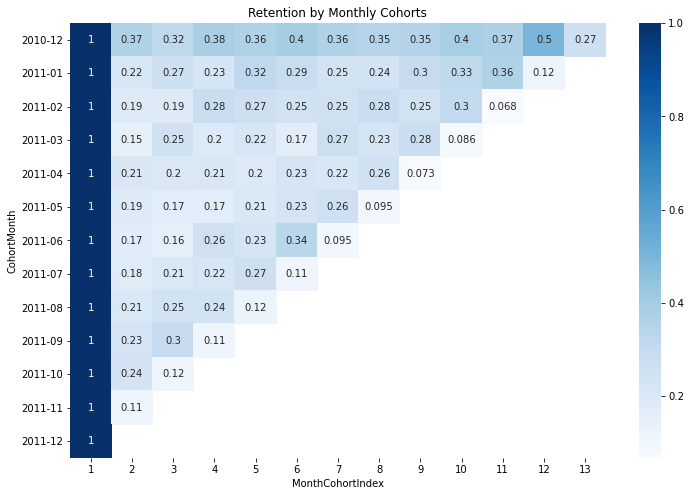

In [10]:
grouping = retail.groupby(['CohortMonth', 'MonthCohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique).reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='MonthCohortIndex', values='CustomerID')
cohort_sizes = cohort_counts.iloc[:,0]
monthly_retention = cohort_counts.divide(cohort_sizes, axis=0).round(3)

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(monthly_retention, annot=True, cmap='Blues', ax=ax)
ax.set(title='Retention by Monthly Cohorts')
plt.show()

## Average Spend Per Invoice by Monthly Cohort

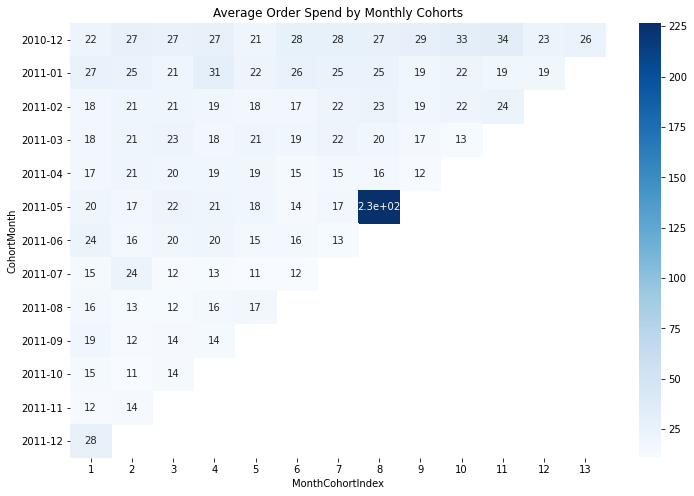

In [11]:
retail['Order_total'] = retail['UnitPrice'] * retail['Quantity']
grouping = retail.groupby(['CohortMonth', 'MonthCohortIndex'])
cohort_data = grouping['Order_total'].mean()
cohort_data = cohort_data.reset_index()
average_spend = cohort_data.pivot(index='CohortMonth',
                                  columns='MonthCohortIndex',
                                  values='Order_total').round(1)


fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(average_spend, annot=True, cmap='Blues', ax=ax)
ax.set(title='Average Order Spend by Monthly Cohorts')
plt.show()

# Create RFM Value, Scores, and Segment

RFM is a strategy for analyzing and estimating the value of a customer, based on three data points. 
- Recency : How recently did the customer make a purchase? (i.e. how many days have past since the last order from each customer?)
- Frequency : How often to customer purchase? (i.e. How many orders (invoices id) have the customer placed so far?)
- Monetary Value : How much do they spend?


Assigning labels to each quantile:
- Highest score to the best metric - best is not always highest e.g. recency
- In this case, the label is inverse - the more recent the customer, the better.

For recency calculation, we will need to define a snapshot date as the cut off date for our analysis.

## RFM Value

In [12]:
snapshot_date = retail['InvoiceDate'].max() + dt.timedelta(days=1) # the next date of the latest date in the record
print(f'Snapshot date: {snapshot_date}')

datamart = retail.groupby('CustomerID').agg({'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
                                            'InvoiceNo': 'nunique',
                                            'Order_total': 'sum'})

datamart.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'Order_total': 'MonetaryValue'}, inplace=True)

datamart.head(5)

Snapshot date: 2011-12-10 12:50:00


,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,326,1,77183.60
12347,2,7,4310.00
12348,75,4,1797.24
12349,19,1,1757.55
12350,310,1,334.40


In [13]:
datamart.describe()

,Recency,Frequency,MonetaryValue
count,4339.000000,4339.000000,4339.000000
mean,92.518322,4.271952,2053.793018
std,100.009747,7.705493,8988.248381
min,1.000000,1.000000,0.000000
25%,18.000000,1.000000,307.245000
50%,51.000000,2.000000,674.450000
75%,142.000000,5.000000,1661.640000
max,374.000000,210.000000,280206.020000


In [14]:
# Discretize 'frequency' variable into equal-sized (counts) buckets
pd.qcut(datamart['Frequency'].rank(method='first'), 3)

CustomerID
12346     (0.999, 1447.0]
12347    (2893.0, 4339.0]
12348    (1447.0, 2893.0]
12349     (0.999, 1447.0]
12350     (0.999, 1447.0]
               ...       
18280    (1447.0, 2893.0]
18281    (1447.0, 2893.0]
18282    (1447.0, 2893.0]
18283    (2893.0, 4339.0]
18287    (1447.0, 2893.0]
Name: Frequency, Length: 4339, dtype: category
Categories (3, interval[float64]): [(0.999, 1447.0] < (1447.0, 2893.0] < (2893.0, 4339.0]]

## RFM Score

Here, we will group RFM values into three equal percentile groups, assigned with labels. The highest label to the best metric.

In [15]:
r_labels = range(4, 0, -1)  # [4, 3, 2, 1]  *The smaller the recency, the bigger the score 
f_labels = range(1, 5)      # [1, 2, 3, 4] 
m_labels = range(1, 5)      # [1, 2, 3, 4] 

# group the RFM values into three equal percentile groups with the defined labels
r_groups = pd.qcut(datamart['Recency'], q=4, labels=r_labels)
f_groups = pd.qcut(datamart['Frequency'].rank(method='first'), q=4, labels=f_labels) # first: ranks assigned in order they appear in the array
m_groups = pd.qcut(datamart['MonetaryValue'], q=4, labels=m_labels)

# assign three columns for three groups
datamart = datamart.assign(R=r_groups, F=f_groups, M=m_groups)

# Calculate RFM_Score
datamart['RFM_Score'] = datamart[['R', 'F', 'M']].sum(axis=1)
datamart['RFM_Score'].head()

CustomerID
12346     6.0
12347    12.0
12348     9.0
12349     8.0
12350     4.0
Name: RFM_Score, dtype: float64

## RFM Segment

In [16]:
# Concat RFM quartile values to create RFM Segments
def rfm_segment(row):
    return str(row['R']) + str(row['F']) + str(row['M'])

datamart['RFM_Segment'] = datamart.apply(rfm_segment, axis=1)

# count num of unique segments
rfm_count_unique = datamart['RFM_Segment'].nunique()
rfm_count_unique

62

In [17]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 9:
        return "Champions"
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return "Can't Lose Them"
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
        return 'Potential'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
        return 'Promising'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'


datamart['RFM_Level'] = datamart.apply(rfm_level, axis=1)
datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score,RFM_Segment,RFM_Level
CustomerID,,,,,,,,,
12346,326,1,77183.60,1,1,4,6.0,114,Potential
12347,2,7,4310.00,4,4,4,12.0,444,Champions
12348,75,4,1797.24,2,3,4,9.0,234,Champions
12349,19,1,1757.55,3,1,4,8.0,314,Can't Lose Them
12350,310,1,334.40,1,1,2,4.0,112,Needs Attention


In [18]:
# Define rfm_level function
def rfm_labels(df):
    if df['RFM_Level'] == "Champions":
        return 1
    elif df['RFM_Level'] == "Can't Loose Them":
        return 2
    elif df['RFM_Level'] == "Loyal":
        return 3
    elif df['RFM_Level'] == "Potential":
        return 4
    elif df['RFM_Level'] == "Promising":
        return 5
    elif df['RFM_Level'] == "Needs Attention":
        return 6
    else:
        return 7
    

datamart['RFM_Labels'] = datamart.apply(rfm_labels, axis=1)
datamart

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score,RFM_Segment,RFM_Level,RFM_Labels
CustomerID,,,,,,,,,,
12346,326,1,77183.60,1,1,4,6.0,114,Potential,4
12347,2,7,4310.00,4,4,4,12.0,444,Champions,1
12348,75,4,1797.24,2,3,4,9.0,234,Champions,1
12349,19,1,1757.55,3,1,4,8.0,314,Can't Lose Them,7
12350,310,1,334.40,1,1,2,4.0,112,Needs Attention,6
...,...,...,...,...,...,...,...,...,...,...
18280,278,1,180.60,1,2,1,4.0,121,Needs Attention,6
18281,181,1,80.82,1,2,1,4.0,121,Needs Attention,6
18282,8,2,178.05,4,3,1,8.0,431,Can't Lose Them,7


## Analysis on RFM segment

In [19]:
datamart['RFM_Level'].unique()

array(['Potential', 'Champions', "Can't Lose Them", 'Needs Attention',
       'Require Activation', 'Promising', 'Loyal'], dtype=object)

In [20]:
level_7 = datamart[datamart['RFM_Labels'] == 7]
level_6 = datamart[datamart['RFM_Labels'] == 6]
level_5 = datamart[datamart['RFM_Labels'] == 5]
level_4 = datamart[datamart['RFM_Labels'] == 4]
level_3 = datamart[datamart['RFM_Labels'] == 3]
level_2 = datamart[datamart['RFM_Labels'] == 2]
level_1 = datamart[datamart['RFM_Labels'] == 1]

data = [level_1,level_2,level_3,level_4,level_4, level_5, level_6,level_7]
colors = ("purple", "green", "blue",'pink','cyan','darkgrey','red')
groups = ["Champions", "Can't Loose Them",'Loyal','Potential', 'Promising',
          'Needs Attention','Require Activation']

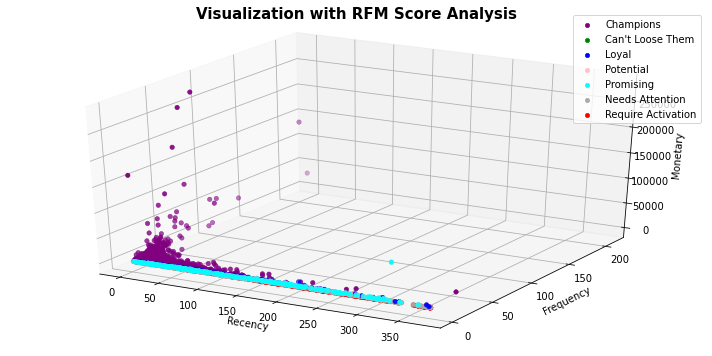

In [21]:
from mpl_toolkits import mplot3d

plt.figure(figsize=(10,5))
ax = plt.axes(projection='3d')
for item,c,g in zip(data, colors, groups):
    ax.scatter(item['Recency'], item['Frequency'], item['MonetaryValue'], c=c,label=g,
           linewidth=0.5)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.suptitle('Visualization with RFM Score Analysis',fontsize=15,fontweight='semibold')
plt.legend()
plt.tight_layout()

In [22]:
datamart.groupby('RFM_Score').agg({'Recency': 'mean',
                                  'Frequency': 'mean',
                                  'MonetaryValue': 'mean',
                                  'RFM_Labels': 'count'})

,Recency,Frequency,MonetaryValue,RFM_Labels
RFM_Score,,,,
3.0,267.711921,1.000000,162.741623,302
4.0,206.841584,1.093069,258.349683,505
5.0,134.741201,1.312629,371.375468,483
6.0,95.106719,1.622530,664.673202,506
7.0,78.087963,2.145833,737.543245,432
8.0,61.176334,2.830626,1137.032645,431
9.0,42.716019,3.660194,1367.402405,412
10.0,34.526854,5.081841,2402.786829,391
11.0,20.853093,7.695876,3794.574897,388


In [23]:
datamart.groupby('RFM_Segment').agg({'Recency': 'mean',
                                  'Frequency': 'mean',
                                  'MonetaryValue': 'mean',
                                  'RFM_Labels': 'count'}).sort_index(ascending=False)

,Recency,Frequency,MonetaryValue,RFM_Labels
RFM_Segment,,,,
444,7.439673,15.539877,9063.926585,489
443,8.508929,6.321429,1257.070536,112
442,7.500000,5.500000,540.685000,4
441,10.333333,6.000000,242.646667,3
434,8.301587,3.936508,3132.097143,63
...,...,...,...,...
121,255.844920,1.251337,181.853797,187
114,263.000000,1.000000,10440.685556,9
113,252.972973,1.000000,999.363784,37


In [24]:
datamart.groupby('RFM_Level').agg({'Recency': 'mean',
                                   'Frequency': 'mean',
                                   'MonetaryValue': 'mean',
                                   'RFM_Labels': 'count'}).sort_values('RFM_Labels', ascending=False)

,Recency,Frequency,MonetaryValue,RFM_Labels
RFM_Level,,,,
Champions,25.492857,8.380952,4409.175358,1680
Potential,95.106719,1.622530,664.673202,506
Needs Attention,206.841584,1.093069,258.349683,505
Promising,134.741201,1.312629,371.375468,483
Loyal,78.087963,2.145833,737.543245,432
Can't Lose Them,61.176334,2.830626,1137.032645,431
Require Activation,267.711921,1.000000,162.741623,302


## K-means Clustering Customers

Assumptions made before applying k-means:
- observations fit a Gaussian distribution (bell curve)
- each feature has similar mean (mean = 0) and standard deviation (std = 1)

### Check assumptions by visualizsing FRM features

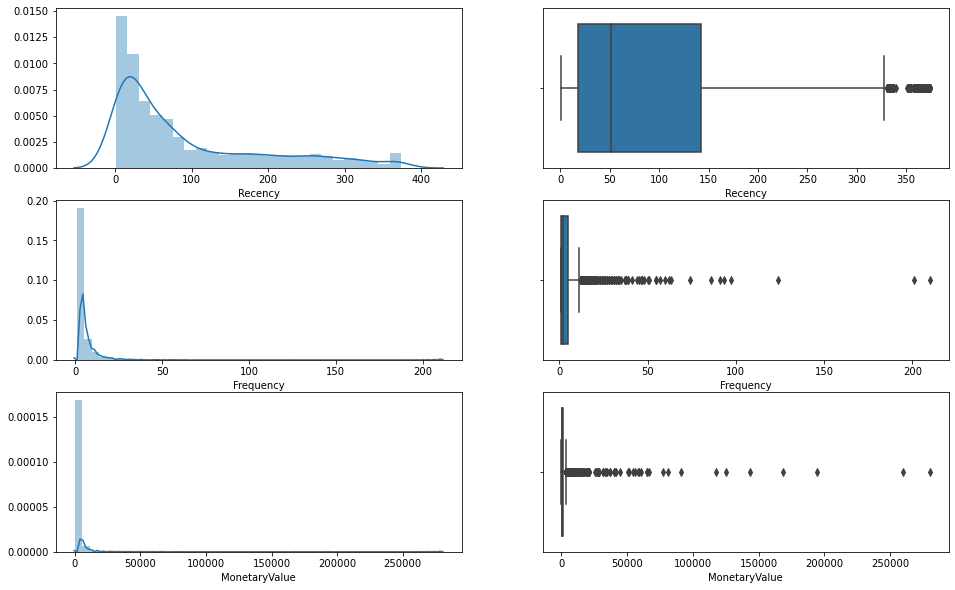

In [25]:
plt.figure(figsize=(16, 10))
plt.subplot(3, 2, 1); sns.distplot(datamart['Recency'])
plt.subplot(3, 2, 2); sns.boxplot(datamart['Recency'])
plt.subplot(3, 2, 3); sns.distplot(datamart['Frequency'])
plt.subplot(3, 2, 4); sns.boxplot(datamart['Frequency'])
plt.subplot(3, 2, 5); sns.distplot(datamart['MonetaryValue'])
plt.subplot(3, 2, 6); sns.boxplot(datamart['MonetaryValue'])

### Data Pre-precessing for k-means
#### Perform Data Standardized/Nomarization

In [26]:
datamart_rfm = datamart[['Recency', 'Frequency', 'MonetaryValue']]

from sklearn.preprocessing import StandardScaler

# Data standarization (center scaling)
scaler = StandardScaler()
scaler.fit(datamart_rfm)
datamart_standardized = scaler.transform(datamart_rfm)
print("standard deviation (R, F, M):", datamart_standardized.std(axis=0))
print("mean (R, F, M):", datamart_standardized.mean(axis=0))

datamart_standardized = pd.DataFrame(data=datamart_standardized, 
                                    index=datamart_rfm.index, 
                                    columns=datamart_rfm.columns)
datamart_standardized

standard deviation (R, F, M): [1. 1. 1.]
mean (R, F, M): [ 7.53283380e-17  1.96508708e-17 -1.63757256e-17]


,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,2.334858,-0.424675,8.359634
12347,-0.905199,0.354080,0.251046
12348,-0.175186,-0.035297,-0.028546
12349,-0.735196,-0.424675,-0.032963
12350,2.174855,-0.424675,-0.191315
...,...,...,...
18280,1.854850,-0.424675,-0.208429
18281,0.884833,-0.424675,-0.219531
18282,-0.845198,-0.294882,-0.208712


#### Check again after standarizing the dataset

We can see the distribution and boxplot from above, many outliers that exist. We need to further standarize the dataset by using `robust scaller` before we jump to k-means clustering.

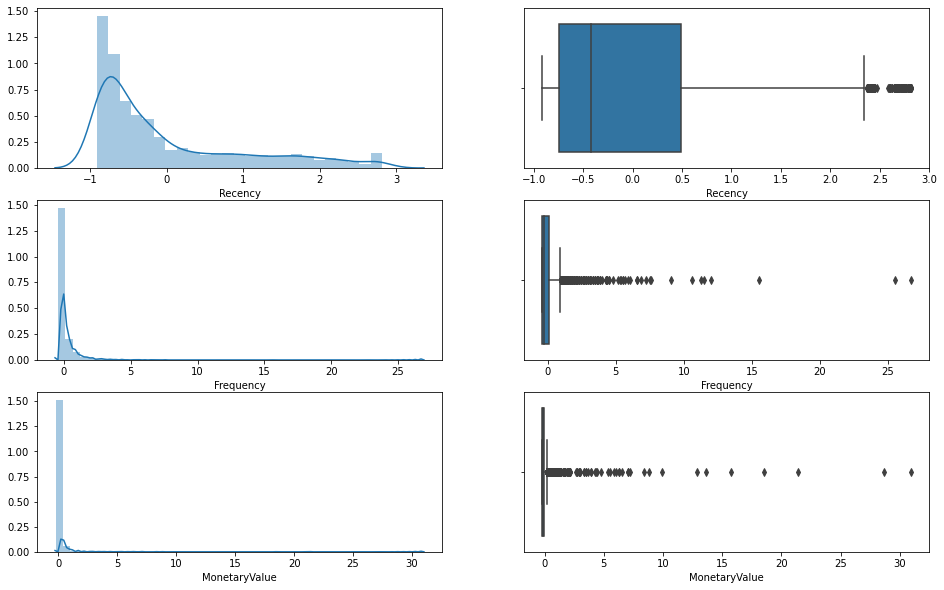

In [27]:
# plot to check 
plt.figure(figsize=(16, 10))
plt.subplot(3, 2, 1); sns.distplot(datamart_standardized['Recency'])
plt.subplot(3, 2, 2); sns.boxplot(datamart_standardized['Recency'])
plt.subplot(3, 2, 3); sns.distplot(datamart_standardized['Frequency'])
plt.subplot(3, 2, 4); sns.boxplot(datamart_standardized['Frequency'])
plt.subplot(3, 2, 5); sns.distplot(datamart_standardized['MonetaryValue'])
plt.subplot(3, 2, 6); sns.boxplot(datamart_standardized['MonetaryValue'])

## Run K-means clustering

In [28]:
from sklearn.cluster import KMeans

# build 4 clusters to start with
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(datamart_standardized)
cluster_labels = kmeans.labels_

# add clustered labels to column 'Cluster'
datamart_rfm_k4 = datamart_rfm.assign(Cluster=cluster_labels)

grouped = datamart_rfm_k4.groupby('Cluster')
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1).sort_values(by=[('Recency', 'mean')], ascending=True)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
2           7.4      82.7      127338.3    13
3          15.6      22.0       12422.3   212
0          44.0       3.7        1347.9  3053
1         248.7       1.6         478.2  1061

## Use Elbow Method to choose the best k value 

In [29]:
sse = {} # sum of the squared distance between centroid and each member of the cluster

for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(datamart_standardized)
    sse[k] = kmeans.inertia_

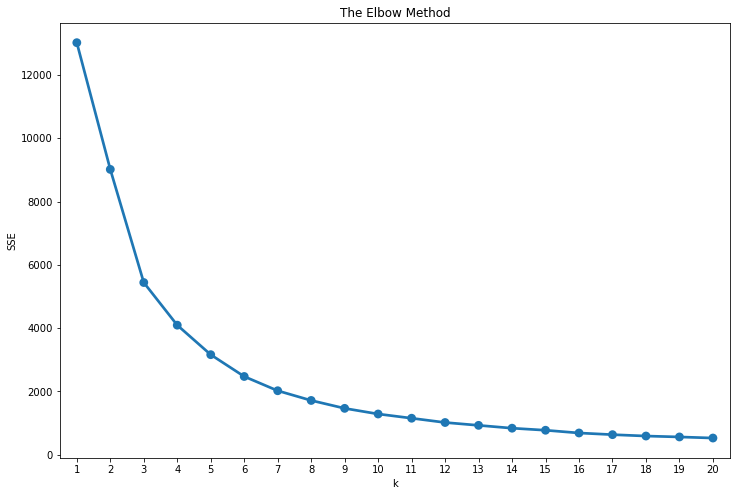

In [30]:
plt.figure(figsize=(12,8))
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

## Use Silhouette Method to choose the best k value

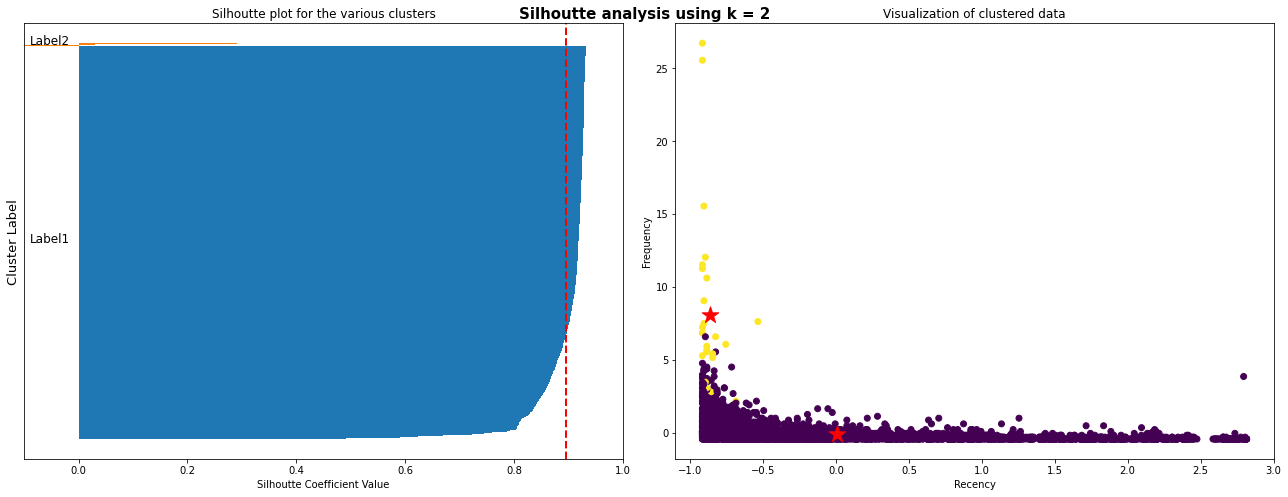

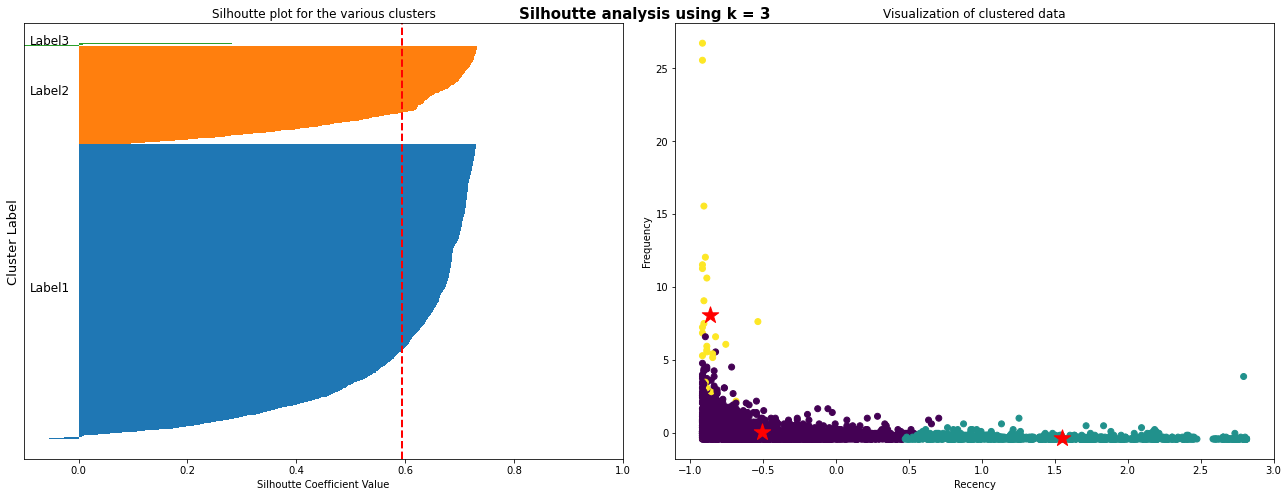

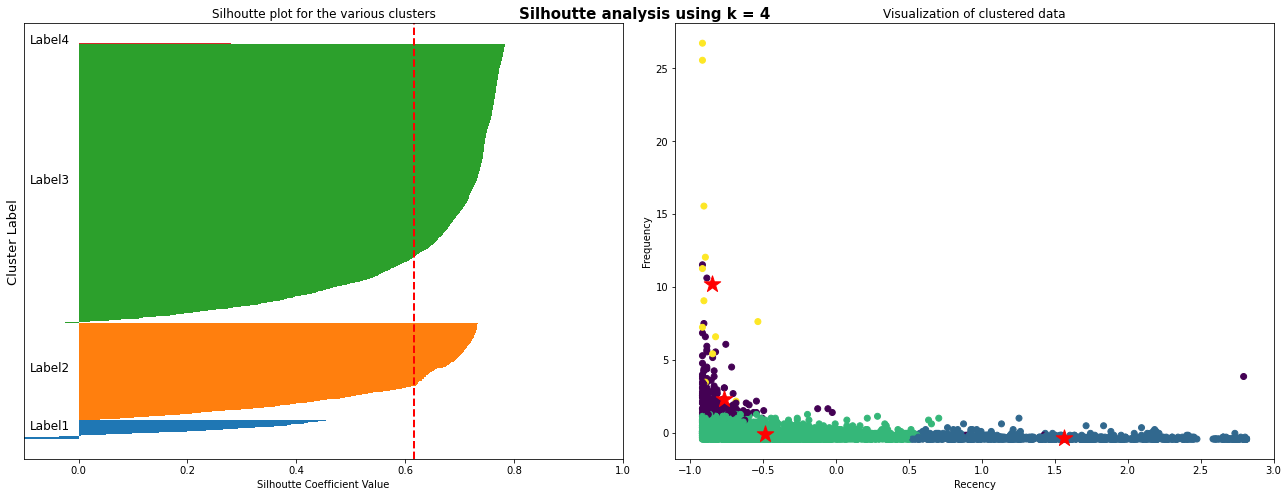

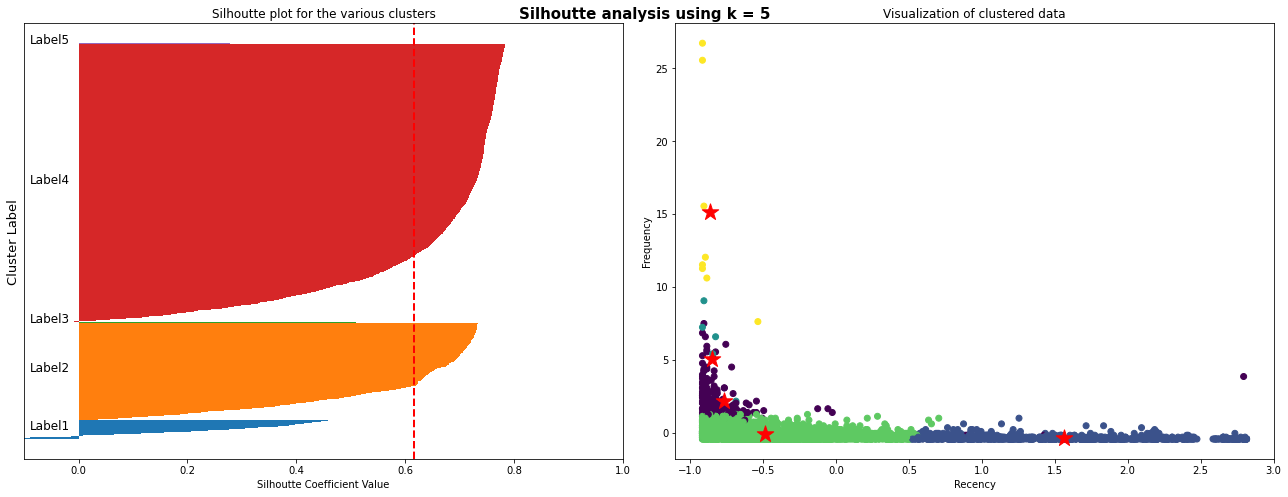

In [31]:
from sklearn.metrics import silhouette_samples

for i,k in enumerate(list(range(2,6))):
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(18,7)
    
    # Running Kmeans Algorithm 
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(datamart_standardized)
    centroids = kmeans.cluster_centers_
    
    ## Get silhoutte samples 
    silhoutte_vals = silhouette_samples(datamart_standardized, labels)
    
    ## Silhoutte plot
    y_ticks = []
    y_lower, y_upper = 0,0
    for i, cluster in enumerate(np.unique(labels)):
        clusters_silhoutte_vals = silhoutte_vals[labels == cluster]
        clusters_silhoutte_vals.sort()
        y_upper += len(clusters_silhoutte_vals)
        ax1.barh(range(y_lower, y_upper), clusters_silhoutte_vals, height=1)
        ax1.text(-0.09,(y_lower+y_upper)/2, 'Label' + str(i+1), fontsize=12)
        y_lower += len(clusters_silhoutte_vals)
        
    ## Get average silhoutte score and using plot above 
    avg_score = np.mean(silhoutte_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth = 2, color='red')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1,1])
    ax1.set_xlabel('Silhoutte Coefficient Value')
    ax1.set_ylabel('Cluster Label', fontsize=13)
    ax1.set_title('Silhoutte plot for the various clusters')
    
    ## Scatter plot of data colored with labels(cluster)
    ax2.scatter(datamart_standardized['Recency'], datamart_standardized['Frequency'], c=labels)
    ax2.scatter(centroids[:,0],centroids[:,1],c='red',marker='*',s=300)
    ax2.set_xlabel('Recency')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Visualization of clustered data')
    plt.suptitle('Silhoutte analysis using k = {}'.format(k),fontsize=15,fontweight='semibold')
    plt.tight_layout()

We can see the result of elbow method and silhoutte method. The best k exists when k = 2. However, we will choose 4 as it contains more information in RFM value.

## Segment profiling

- use snake plot
- relative importance of each attribute

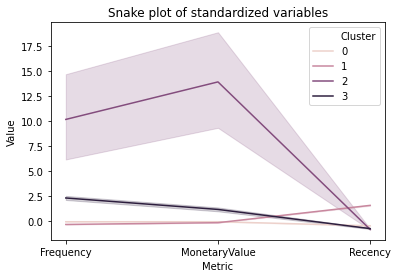

In [32]:
datamart_standardized = datamart_standardized.assign(Cluster=datamart_rfm_k4['Cluster'].values)

# melt the data into a long format so RFM values and metric names are stored in 1 column each
datamart_melt = pd.melt(datamart_standardized.reset_index(),
                        id_vars=['CustomerID', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'MonetaryValue'],
                        var_name='Metric', value_name='Value')

plt.title('Snake plot of standardized variables')
plt.xlabel('Metric')
plt.ylabel('Value')
sns.lineplot(data=datamart_melt, x='Metric', y='Value', hue='Cluster')
plt.show()

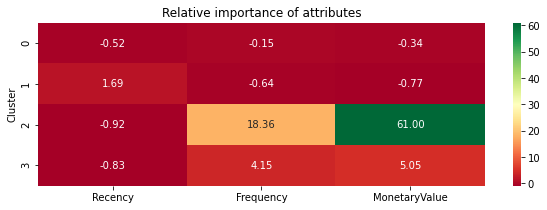

In [34]:
cluster_avg = datamart_rfm_k4.groupby('Cluster').mean()
population_avg = datamart_rfm.mean()

# calculate relative importance of cluster's attribute value compared to population
relative_imp = cluster_avg / population_avg - 1
plt.figure(figsize=(10, 3))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

The farther a ratio is from zero, the more important that attribute is for a segment relative to the total population.
Here, we can see `Monetary value` and `Frequency` in cluster 2 have higher importance relative to general population.